In [4]:
import logging
import os
from sacred import Experiment
import numpy as np
import seml
from tensorboard import program

import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import models

from losses.losses import *
from utils.utils import *
from datasets.datasets import SegmentationDataSet
from datasets.data_constants import *
from models.discriminator import FCDiscriminator, FCDiscriminatorBatchNorm

import importlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# data params
source_dir = '/nfs/students/mirlas/data/'
target_dir = '/nfs/students/mirlas/data/'

snapshots_dir = '/nfs/students/mirlas/snapshots/seg_da_small/'
log_dir = '/nfs/students/mirlas/logdir/seg_da_small/'
pred_dir = '/nfs/students/mirlas/predictions/seg_da_small/'
load_checkpoint = '/nfs/students/mirlas/snapshots/seg/resnet50_fcn_400x800_IN_ce_gamma0.0e+00_lr2.5e-04_m9.0e-01_wd5.0e-04_lrsp9.0e-01/checkpoint_10.pth'

source_train_images = 'gta5_images_train.txt'
source_train_labels = 'gta5_labels_train.txt'
source_val_images = 'gta5_images_val.txt'
source_val_labels = 'gta5_labels_val.txt'
target_train_images = 'cityscapes_images_train.txt'
target_train_labels = 'cityscapes_labels_train.txt'
target_val_images = 'cityscapes_images_val.txt'
target_val_labels = 'cityscapes_labels_val.txt' 

train_batch_size = 2
val_batch_size = 2
image_height = 400
image_width = 800
num_workers = 8

# network params
backbone = 'resnet50'
classification_head = 'fcn'
pretrained_backbone = True
segmentation_loss = 'ce'
gamma = 0.0

da_injection_point = 'output'
lambda_da = 100

# optim params
learning_rate = 2.5e-4
momentum = 0.9
weight_decay = 0.0005
lrs_power = 0.9
learning_rate_da = 1e-4
betas_da = [0.9, 0.99]

# training loop params
max_iter = 400000
batches_to_eval_train = 1
batches_to_visualize = 1
points_to_sample = 50
save_step = 1
display_step = 1
seed = 42

In [6]:
logger = logging.getLogger()
logger.handlers = []
ch = logging.StreamHandler()
formatter = logging.Formatter(
        fmt='%(asctime)s (%(levelname)sz): %(message)s',
        datefmt='%Y-%m-%d %H:%M:%S')
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.setLevel('INFO')

In [7]:
#  initialize the global parameters
cuda_status = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda_status else "cpu")
image_size = (image_height, image_width)
model_name = '_'.join(
        [backbone,
        classification_head,
        str(image_height) + 'x' + str(image_width),
        ('IN' if pretrained_backbone else ''),
        segmentation_loss,
        da_injection_point,
        'gamma{:.1e}_lmbdda{:.1e}_lr{:.1e}_lrda{:.1e}_m{:.1e}_wd{:.1e}_lrsp{:.1e}'.format(
            gamma, lambda_da, learning_rate, learning_rate_da, momentum, weight_decay, lrs_power)
        ])
start_epoch = 0
src_label = 1.
tar_label = 0.
if seed > 0:
    torch.manual_seed(seed)

In [8]:
model_name

'resnet50_fcn_400x800_IN_ce_output_gamma0.0e+00_lmbdda1.0e+02_lr2.5e-04_lrda1.0e-04_m9.0e-01_wd5.0e-04_lrsp9.0e-01'

In [9]:
#  create neccessary directories for snapshots and logs
if not os.path.exists(os.path.join(snapshots_dir, model_name)):
    os.makedirs(os.path.join(snapshots_dir, model_name))
if not os.path.exists(os.path.join(log_dir, model_name)):
    os.makedirs(os.path.join(log_dir, model_name))
if not os.path.exists(os.path.join(pred_dir, model_name)):
    os.makedirs(os.path.join(pred_dir, model_name))

In [10]:
#  initialize the datasets
source_train_dataset = SegmentationDataSet(root=source_dir, image_list_name=source_train_images, 
                            label_list_name=source_train_labels, size=image_size, 
                            mean=GTA5_MEAN, std=GTA5_STD, label2train=GTA5_LABELS2TRAIN)
source_val_dataset = SegmentationDataSet(root=target_dir, image_list_name=source_val_images, 
                        label_list_name=source_val_labels, size=image_size, 
                        mean=GTA5_MEAN, std=GTA5_STD, label2train=GTA5_LABELS2TRAIN)
target_train_dataset = SegmentationDataSet(root=target_dir, image_list_name=target_train_images, 
                        label_list_name=target_train_labels, size=image_size, 
                        mean=CITYSCAPES_MEAN, std=CITYSCAPES_STD, label2train=CITYSCAPES_LABELS2TRAIN)
target_val_dataset = SegmentationDataSet(root=target_dir, image_list_name=target_val_images, 
                        label_list_name=target_val_labels, size=image_size, 
                        mean=CITYSCAPES_MEAN, std=CITYSCAPES_STD, label2train=CITYSCAPES_LABELS2TRAIN)

In [11]:
source_train_dataloader = DataLoader(source_train_dataset, batch_size=train_batch_size,
                                shuffle=True, pin_memory=cuda_status, drop_last=True, num_workers=num_workers)
target_train_dataloader = DataLoader(target_train_dataset, batch_size=train_batch_size,
                            shuffle=True, pin_memory=cuda_status, drop_last=True, num_workers=num_workers)
source_val_dataloader = DataLoader(source_val_dataset, batch_size=val_batch_size,
                            shuffle=True, pin_memory=cuda_status, drop_last=True, num_workers=num_workers)
target_val_dataloader = DataLoader(target_val_dataset, batch_size=val_batch_size, 
                            shuffle=True, pin_memory=cuda_status, drop_last=True, num_workers=num_workers)

In [12]:
inf_source_train_dataloader = inf_iter(source_train_dataloader)
inf_target_train_dataloader = inf_iter(target_train_dataloader)
inf_source_val_dataloader = inf_iter(source_val_dataloader)
inf_target_val_dataloader = inf_iter(target_val_dataloader)

In [13]:
inf_source_val_dataloader = inf_iter(source_val_dataloader)
inf_target_val_dataloader = inf_iter(target_val_dataloader)
inf_source_train_dataloader = inf_iter(source_train_dataloader)
inf_target_train_dataloader = inf_iter(target_train_dataloader)

In [14]:
max_epochs = max_iter // len(source_train_dataloader)

In [15]:
print('Source train dataloader length: ', len(source_train_dataloader))
print('Source val dataloader length: ', len(source_val_dataloader))
print('Source val dataloader length: ', len(target_train_dataloader))
print('Target val dataloader length: ', len(target_val_dataloader))

Source train dataloader length:  9986
Source val dataloader length:  2496
Source val dataloader length:  1487
Target val dataloader length:  250


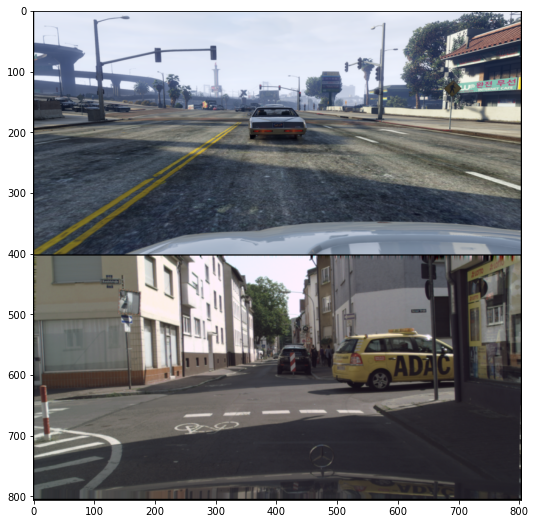

In [16]:
# plot the images
source_sample = source_val_dataset[0]
target_sample = target_val_dataset[0]

grid = make_grid([source_sample['image'], 
                  target_sample['image']],
                nrow=1,
                normalize=True,
                scale_each=True)

plt.imshow(grid.permute(1, 2, 0))

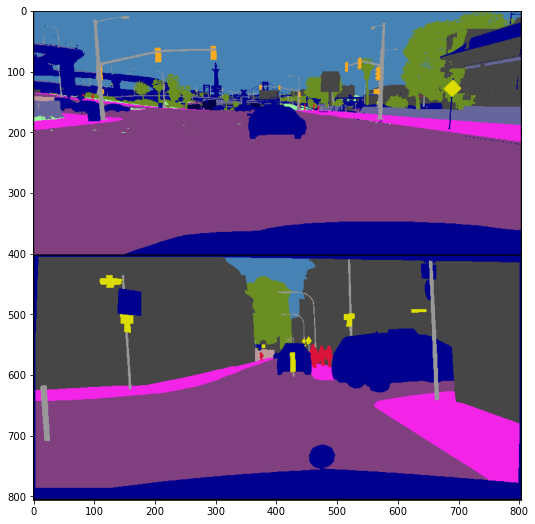

In [17]:
# plot the GTs
source_sample_color_map = create_color_map(source_sample['gt'],
                                          GTA5_LABELS2TRAIN,
                                          GTA5_LABELS2PALETTE)
target_sample_color_map = create_color_map(target_sample['gt'],
                                          CITYSCAPES_LABELS2TRAIN,
                                          CITYSCAPES_LABELS2PALETTE)

grid = make_grid([source_sample_color_map, 
                  target_sample_color_map],
                 nrow=1,
                 normalize=False,
                 scale_each=False)

plt.imshow(grid.permute(1, 2, 0))

In [18]:
#  initialize the model and the loss
#  segmentation model
seg_model_name =  classification_head + '_' + backbone
seg_model_loader = getattr(models.segmentation, seg_model_name)
seg_model = seg_model_loader(pretrained=False, 
                num_classes=NUM_CLASSES,
                progress=False,
                aux_loss=False,
                pretrained_backbone=pretrained_backbone)
if segmentation_loss == 'ce':
    seg_loss = torch.nn.CrossEntropyLoss(ignore_index=255)
elif segmentation_loss == 'focal':
    seg_loss = FocalLoss(alpha=1.0, 
                gamma=gamma, 
                ignore_index=255,
                reduction='mean')
else:
    raise ValueError("There are two losses currently supported: [ce, focal]. "
                     "Got: {}".format(segmentation_loss))

In [20]:
#  domain discriminator
if da_injection_point == 'output':
    discriminator_config = {
        'input_dim': NUM_CLASSES,
        'ndf': 64,
    }
elif da_injection_point == 'feature':
    discriminator_config = {
        'input_dim': 2048,
        'ndf': 256,
    }
else:
    raise ValueError("There are two injection points currently supported: [output, feature]. "
                     "Got: {}".format(da_injection_point))
discr_model = FCDiscriminatorBatchNorm(**discriminator_config)
discr_loss = torch.nn.BCEWithLogitsLoss()

In [21]:
#  initialize the optimizer 
#  we use different lrs for the classifier and the backbone if the latter one is pretrained
optimizer = torch.optim.SGD([{'params': seg_model.backbone.parameters(), 
                              'lr':learning_rate},
                             {'params': seg_model.classifier.parameters(), 
                              'lr':learning_rate * (10 if pretrained_backbone else 1)}],
                            lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
optimizer.zero_grad()

In [22]:
discr_optimizer = torch.optim.Adam(discr_model.parameters(), 
                                lr=learning_rate_da, betas=betas_da)
discr_optimizer.zero_grad()

In [23]:
#  initialize the learning rate scheduler
lr_poly = lambda epoch: (1 - epoch / max_epochs) ** lrs_power
# lr_poly = lambda epoch: 1 ** lrs_power
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_poly, last_epoch=-1)
discr_scheduler = torch.optim.lr_scheduler.LambdaLR(discr_optimizer, lr_lambda=lr_poly, last_epoch=-1)

In [84]:
import glob
checkpoint_list = glob.glob('/nfs/students/mirlas/snapshots/seg_da/*/*.pth')

checkpoint_list

for load_checkpoint in checkpoint_list:
    #  reinitialize if nesseccary
    if os.path.isfile(load_checkpoint):
        checkpoint = torch.load(load_checkpoint)
        print(load_checkpoint, checkpoint['discr_model']['main.0.weight'].shape)
        checkpoint['discr_scheduler'] = {
            'last_epoch': checkpoint['scheduler']['last_epoch'],
            'base_lrs': [d['initial_lr'] for d in checkpoint['discr_optimizer']['param_groups']],
            '_step_count': checkpoint['scheduler']['_step_count'],
            '_get_lr_called_within_step': checkpoint['scheduler']['_get_lr_called_within_step'],
            '_last_lr': [d['lr'] for d in checkpoint['discr_optimizer']['param_groups']],
            'lr_lambdas': [None]*len(checkpoint['discr_optimizer']['param_groups'])
        }
        torch.save(checkpoint, load_checkpoint)

/nfs/students/mirlas/snapshots/seg_da/resnet50_fcn_400x800_IN_ce_feature_gamma0.0e+00_lmbdda1.0e-02_lr2.5e-04_lrda1.0e-04_m9.0e-01_wd5.0e-04_lrsp9.0e-01/checkpoint_10.pth torch.Size([256, 2048, 4, 4])
/nfs/students/mirlas/snapshots/seg_da/resnet50_fcn_400x800_IN_ce_feature_gamma0.0e+00_lmbdda1.0e-02_lr2.5e-04_lrda1.0e-04_m9.0e-01_wd5.0e-04_lrsp9.0e-01/checkpoint_20.pth torch.Size([256, 2048, 4, 4])
/nfs/students/mirlas/snapshots/seg_da/resnet50_fcn_400x800_IN_ce_output_gamma0.0e+00_lmbdda1.0e-01_lr2.5e-04_lrda1.0e-04_m9.0e-01_wd5.0e-04_lrsp9.0e-01/checkpoint_10.pth torch.Size([64, 19, 4, 4])
/nfs/students/mirlas/snapshots/seg_da/resnet50_fcn_400x800_IN_ce_output_gamma0.0e+00_lmbdda1.0e-01_lr2.5e-04_lrda1.0e-04_m9.0e-01_wd5.0e-04_lrsp9.0e-01/checkpoint_20.pth torch.Size([64, 19, 4, 4])
/nfs/students/mirlas/snapshots/seg_da/resnet50_fcn_400x800_IN_ce_output_gamma0.0e+00_lmbdda1.0e-03_lr2.5e-04_lrda1.0e-04_m9.0e-01_wd5.0e-04_lrsp9.0e-01/checkpoint_10.pth torch.Size([64, 19, 4, 4])
/nfs/st

In [24]:
#  reinitialize if nesseccary
if os.path.isfile(load_checkpoint):
    checkpoint = torch.load(load_checkpoint)

In [29]:
if 'seg_model' in checkpoint:
    seg_model.load_state_dict(checkpoint['seg_model'])
if 'discr_model' in checkpoint:
    discr_model.load_state_dict(checkpoint['discr_model'])
if 'optimizer' in checkpoint:
    optimizer.load_state_dict(checkpoint['optimizer'])
if 'discr_optimizer' in checkpoint:
    discr_optimizer.load_state_dict(checkpoint['discr_optimizer'])
if 'scheduler' in checkpoint:
    scheduler.load_state_dict(checkpoint['scheduler'])
if 'discr_scheduler' in checkpoint:
    discr_scheduler.load_state_dict(checkpoint['discr_scheduler'])
if 'epoch' in checkpoint:
    start_epoch = checkpoint['epoch'] + 1

/nfs/homedirs/mirlas/anaconda3/envs/ssda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:218: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


In [32]:
#  move everything to a device
transfer_model_and_optimizer(seg_model, optimizer, device)
transfer_model_and_optimizer(discr_model, discr_optimizer, device)

In [33]:
#  initialize the SummaryWriter
summary_path = os.path.join(log_dir, model_name)
writer = SummaryWriter(log_dir=summary_path)

In [34]:
#  initialize loss, accuracy values
running_src_seg_loss = 0.0
running_tar_fake_loss = 0.0
running_domain_loss = 0.0
running_cm = torch.zeros(NUM_CLASSES, NUM_CLASSES, device=device)

In [35]:
seg_model.train()
discr_model.train()

FCDiscriminatorBatchNorm(
  (main): Sequential(
    (0): Conv2d(19, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  )
)

In [36]:
epoch = 0
batch_idx = 0
for num_iter in range(start_epoch*len(source_train_dataloader), 
                      max_epochs*len(source_train_dataloader)):
    if num_iter % len(source_train_dataloader) == 0:
        epoch = num_iter // len(source_train_dataloader)
        logging.info(f'Epoch: {epoch}/{max_epochs}')
    batch_idx = num_iter % len(source_train_dataloader)

    #  zero the parameter gradients
    optimizer.zero_grad()
    discr_optimizer.zero_grad()

    #  forward pass TARGET image
    #  load target data
    _, data = next(inf_target_train_dataloader)
    image, gt, name = data['image'], data['gt'], data['name']
    image = image.to(device)
    gt = gt.to(device)

    #  forward pass encoder + segmentation
    features = seg_model.backbone(image)
    output = seg_model.classifier(features['out'])
    output = F.interpolate(output, image_size, 
                mode='bilinear', align_corners=False)

    #  forward pass dicriminator to compute fake_loss
    for param in discr_model.parameters():
        param.requires_grad = False
    if da_injection_point == 'output':
        da_output = discr_model(output)
    else:
        da_output = discr_model(features['out'])

    #  backprop encoder + segmentation
    domain_label = torch.full_like(da_output, src_label, device=device)
    tar_fake_loss = lambda_da * discr_loss(da_output, domain_label)
    tar_fake_loss.backward()
    
    #  forward pass dicriminator to compute classification loss
    for param in discr_model.parameters():
        param.requires_grad = True
    discr_model.zero_grad()
    if da_injection_point == 'output':
        da_output = discr_model(output.detach())
    else:
        da_output = discr_model(features['out'].detach())

    #  backprop discriminator
    domain_label.fill_(tar_label)
    tar_domain_loss = 0.5 * discr_loss(da_output, domain_label)
    tar_domain_loss.backward()

    #  forward pass SOURCE image
    #  load source data
    _, data = next(inf_source_train_dataloader)
    image, gt, name = data['image'], data['gt'], data['name']
    image = image.to(device)
    gt = gt.to(device)

    #  forward pass encoder + segmentation
    for param in discr_model.parameters():
            param.requires_grad = False
    features = seg_model.backbone(image)
    output = seg_model.classifier(features['out'])
    output = F.interpolate(output, image_size, 
                mode='bilinear', align_corners=False)

    #  backprop encoder + segmentation
    src_seg_loss = seg_loss(output, gt)
    src_seg_loss.backward()
    
    #  forward pass dicriminator
    for param in discr_model.parameters():
            param.requires_grad = True
    if da_injection_point == 'output':
        da_output = discr_model(output.detach())
    else:
        da_output = discr_model(features['out'].detach())

    #  backprop discriminator
    domain_label.fill_(src_label)
    src_domain_loss = 0.5 * discr_loss(da_output, domain_label)
    src_domain_loss.backward()

    optimizer.step()
    discr_optimizer.step()

    #  update metrics
    with torch.no_grad():
        running_src_seg_loss += src_seg_loss.item()
        running_tar_fake_loss += tar_fake_loss.item()
        running_domain_loss += (tar_domain_loss.item() + src_domain_loss.item())
        src_seg_pred = output.argmax(1)
        running_cm += fast_hist(src_seg_pred, gt, NUM_CLASSES)

    #  update the training summary stats: metrics and images
    if (batch_idx + 1) % display_step == 0:
        with torch.no_grad():
            #  train
            pixel_train_acc = pixel_acc(running_cm)
            classwise_train_iou = per_class_iou(running_cm)

            #  val
            src_val_metrics = evaluate_segmentation_set(inf_source_val_dataloader, batches_to_eval_train, 
                seg_model, seg_loss, NUM_CLASSES, device)
            tar_val_metrics = evaluate_segmentation_set(inf_target_val_dataloader, batches_to_eval_train, 
                seg_model, seg_loss, NUM_CLASSES, device)

        logging.info('Iteration {}/{}: Loss: {:.4f} | Pixel accuracy: {:.4f}'.format(batch_idx+1, 
                                                                              len(source_train_dataloader), 
                                                                              src_seg_loss.item(), 
                                                                              pixel_train_acc))

        #  write summary
        writer.add_scalars('Seg_loss', 
            {'training_src_seg_loss': running_src_seg_loss/display_step,
             'validation_src_seg_loss': src_val_metrics['loss'],
             'validation_tar_seg_loss': tar_val_metrics['loss']},
            num_iter)
        writer.add_scalars('Discr_loss', 
            {'training_tar_fake_loss': running_tar_fake_loss/lambda_da/display_step,
             'training_domain_loss': running_domain_loss/display_step},
            num_iter)
        writer.add_scalars('Pixel_iou',
            {'training_src_pixel_acc': pixel_train_acc,
             'validation_src_pixel_acc': src_val_metrics['pixel_accuracy'],
             'validation_target_pixel_acc': tar_val_metrics['pixel_accuracy']},
            num_iter)
        for i in range(NUM_CLASSES):
            writer.add_scalar('Class_iou/{}'.format(CLASSES[i]),
                classwise_train_iou[i] if not classwise_train_iou[i] == float('nan') else 0.0,
                num_iter)

        #  reset loss, accuracy values
        running_src_seg_loss = 0.0
        running_tar_fake_loss = 0.0
        running_domain_loss = 0.0
        running_cm.fill_(0.0)

    #  write images to the summary (twice per epoch)
    if (epoch + 1) % 50 == 0:
#     if (batch_idx + 1) == len(source_train_dataloader) or \
#         (batch_idx + 1) == len(source_train_dataloader) // 2 or \
#         (batch_idx + 1) == len(source_train_dataloader) // 4 or \
#         (batch_idx + 1) == 3 * len(source_train_dataloader) // 4:
        logging.info('Writing summary images')
        with torch.no_grad():
            #  train
            for i in range(len(image)):
                train_src_summary_image = compile_summary_image(image[i], output[i], gt[i], 
                    GTA5_MEAN, GTA5_STD, GTA5_LABELS2TRAIN, GTA5_LABELS2PALETTE, scale_factor=0.5)
                writer.add_image('Train/Src',
                    img_tensor=train_src_summary_image, 
                    global_step=num_iter+i, 
                    walltime=None, 
                    dataformats='CHW')
            #  val
            write_summary_images(writer, inf_source_val_dataloader, 
                GTA5_MEAN, GTA5_STD, GTA5_LABELS2TRAIN, GTA5_LABELS2PALETTE, 
                seg_model, device, 
                num_batches=1, tag='Val/Src', scale_factor=0.5, global_step=num_iter)
            write_summary_images(writer, inf_target_val_dataloader, 
                CITYSCAPES_MEAN, CITYSCAPES_STD, CITYSCAPES_LABELS2TRAIN, CITYSCAPES_LABELS2PALETTE, 
                seg_model, device, 
                num_batches=1, tag='Val/Tar', scale_factor=0.5, global_step=num_iter)

    #  end_of_epoch
    if (num_iter + 1) % len(source_train_dataloader) == 0:
        #  decay lr
        logging.info('LR update')
        scheduler.step()
        discr_scheduler.step()

#         #  save the model    
#         if (epoch + 1) % save_step == 0:
#             print('Save the model')
#             save_path = os.path.join(snapshots_dir, model_name, 'checkpoint_{}.pth'.format(epoch+1))
#             torch.save({
#                 'seg_model': seg_model.state_dict(),
#                 'discr_model': discr_model.state_dict(),
#                 'optimizer': optimizer.state_dict(),
#                 'discr_optimizer': discr_optimizer.state_dict(),
#                 'scheduler': scheduler.state_dict(),
#                 'discr_scheduler': discr_scheduler.state_dict(),
#                 'epoch': epoch}, save_path)

2020-09-08 12:49:43 (INFOz): Epoch: 10/40
2020-09-08 12:49:50 (INFOz): Iteration 1/9986: Loss: 0.2755 | Pixel accuracy: 0.9246
2020-09-08 12:49:52 (INFOz): Iteration 2/9986: Loss: 0.1787 | Pixel accuracy: 0.9437
2020-09-08 12:49:54 (INFOz): Iteration 3/9986: Loss: 0.3095 | Pixel accuracy: 0.9244
2020-09-08 12:49:55 (INFOz): Iteration 4/9986: Loss: 1.0817 | Pixel accuracy: 0.8787
2020-09-08 12:49:57 (INFOz): Iteration 5/9986: Loss: 2.1462 | Pixel accuracy: 0.7374
2020-09-08 12:49:58 (INFOz): Iteration 6/9986: Loss: 3.4921 | Pixel accuracy: 0.4354
2020-09-08 12:50:00 (INFOz): Iteration 7/9986: Loss: 3.2524 | Pixel accuracy: 0.3942
2020-09-08 12:50:02 (INFOz): Iteration 8/9986: Loss: 3.0467 | Pixel accuracy: 0.5518
2020-09-08 12:50:04 (INFOz): Iteration 9/9986: Loss: 3.2349 | Pixel accuracy: 0.4057
2020-09-08 12:50:05 (INFOz): Iteration 10/9986: Loss: 3.5931 | Pixel accuracy: 0.3320
2020-09-08 12:50:07 (INFOz): Iteration 11/9986: Loss: 4.4052 | Pixel accuracy: 0.2524
2020-09-08 12:50:08 (

KeyboardInterrupt: 

In [ ]:
#  evaluate the model
seg_model.eval()
discr_model.eval()
with torch.no_grad():
    src_val_metrics = evaluate_segmentation_set(inf_source_val_dataloader, len(source_val_dataloader), 
        seg_model, seg_loss, NUM_CLASSES, device)
    tar_val_metrics = evaluate_segmentation_set(inf_target_val_dataloader, len(target_val_dataloader), 
        seg_model, seg_loss, NUM_CLASSES, device)
print(src_val_metrics)
print(tar_val_metrics)

In [26]:
#  write results
results = dict()
results.update({'src_'+k: v for k, v in src_val_metrics.items()})
results.update({'tar_'+k: v for k, v in tar_val_metrics.items()})
print(results)

{'src_loss': 1.1799275875091553, 'src_pixel_accuracy': 0.6868902444839478, 'src_classwise_iou': [0.764542818069458, 0.26363605260849, 0.4527710974216461, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1247950866818428, 0.0, 0.6914544105529785, 0.0, nan, 0.0, 0.0, 0.0, nan, 0.0, 0.0], 'tar_loss': 1.3432286083698273, 'tar_pixel_accuracy': 0.6828340888023376, 'tar_classwise_iou': [0.7752176523208618, 0.0934637039899826, 0.5916734933853149, nan, 0.0, 0.0, 0.0, 0.0, 0.18590576946735382, 0.0, 0.359559029340744, 0.0, 0.0, 0.0, 0.0, nan, nan, 0.0, 0.0]}


In [27]:
predictions_path = os.path.join(pred_dir, model_name)

In [28]:
predictions_path

'/nfs/students/mirlas/predictions/seg_da_small/resnet101_deeplabv3_512x1024_IN_feature_lr2.5e-04_lrda1.0e-04_m9.0e-01_wd5.0e-04_lrsp9.0e-01'

In [29]:
with torch.no_grad():
    write_predictions(source_val_dataloader, seg_model, device, 
            batches_to_visualize, predictions_path, 
            GTA5_MEAN, GTA5_STD, GTA5_LABELS2TRAIN, 
            GTA5_LABELS2PALETTE, prefix='src_')

In [30]:
with torch.no_grad():
    write_predictions(target_val_dataloader, seg_model, device, 
            batches_to_visualize, predictions_path, 
            CITYSCAPES_MEAN, CITYSCAPES_STD, CITYSCAPES_LABELS2TRAIN,
            CITYSCAPES_LABELS2PALETTE, prefix='tar_')

In [31]:
with torch.no_grad():
    create_embeddings(writer, inf_source_val_dataloader, inf_target_val_dataloader, 
            seg_model, device, 
            batches_to_visualize, points_to_sample)